In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env


In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   request_path    13978 non-null  object
 4   http_version    13978 non-null  object
 5   status_code     13978 non-null  object
 6   size            13978 non-null  int64 
 7   user_agent      13978 non-null  object
dtypes: int64(1), object(7)
memory usage: 982.8+ KB


In [5]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')


In [6]:
# Detecting Anomalies: count and frequency
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [7]:
df.ip.nunique()

22

In [8]:
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

In [9]:
# let's put this info into a df through a function:
def value_counts_and_frequencies(s:pd.Series, dropna=True):
    return pd.merge(
    s.value_counts(dropna=False).rename('count'),
    s.value_counts(dropna=False, normalize=True).rename('proba'),
    left_index=True,
    right_index=True)

In [10]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<AxesSubplot:>

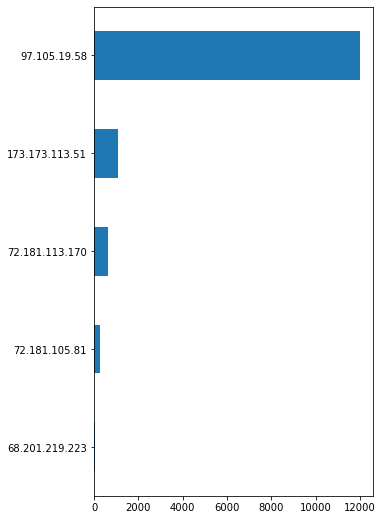

In [11]:
# find out how many unique queries there are, per IP address:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5,9))

In [12]:
# conditional probabilites: probs using 2 discrete variables
status_given_ip = (df.groupby('ip').status_code.value_counts(normalize=True)
                  .rename('proba_status_given_ip')
                         .reset_index()
                  )
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [13]:
# let's find non-200 ip status responses:
status_given_ip[status_given_ip.status_code!='200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [14]:
# investigate these ips further:
status_given_ip[status_given_ip.ip=='97.105.15.120']

,ip,status_code,proba_status_given_ip
21,97.105.15.120,301,1.0


In [15]:
# now pull the full df with this IP's info:
df[df.ip=='97.105.15.120']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [16]:
# look at logs for IPs where proportion of requests is < 100%:
status_given_ip[status_given_ip.proba_status_given_ip<1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [26]:
# replicate the process for request_method

request_df = value_counts_and_frequencies(df.request_method)
request_df.head()

,count,proba
GET,13978,1.0


<AxesSubplot:>

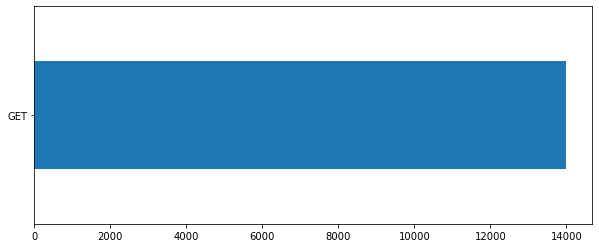

In [27]:
request_df['count'].sort_values().tail(5).plot.barh(figsize=(10,4))

In [33]:
request_method_given_ip = (df.groupby('ip').request_method.value_counts(normalize=True)
                    .rename('request_method_given_ip')
                   ).reset_index()
request_method_given_ip.head()

,ip,request_method,request_method_given_ip
0,173.173.113.51,GET,1.0
1,24.26.242.9,GET,1.0
2,3.88.129.158,GET,1.0
3,3.92.201.136,GET,1.0
4,34.207.64.242,GET,1.0


In [34]:
request_method_given_ip[request_given_ip.request_method!='GET']

,ip,request_method,request_method_given_ip


In [35]:
request_method_given_ip.request_method.unique()

array(['GET'], dtype=object)

In [36]:
# replicate the method for the request path:
request_path_df = value_counts_and_frequencies(df.request_path)
request_path_df.head()

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590


<AxesSubplot:>

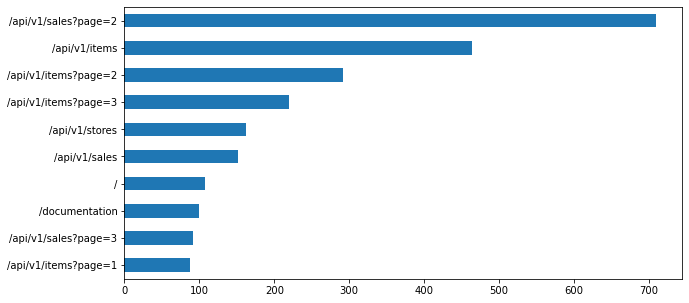

In [37]:
request_path_df['count'].sort_values().tail(10).plot.barh(figsize=(10,5))

In [39]:
request_path_given_ip = (df.groupby('ip').request_path.value_counts(normalize=True)
                        .rename('request_path_given_ip')
                        .reset_index())
request_path_given_ip.head()


,ip,request_path,request_path_given_ip
0,173.173.113.51,/api/v1/items,0.060434
1,173.173.113.51,/api/v1/items?page=2,0.058546
2,173.173.113.51,/api/v1/items?page=3,0.058546
3,173.173.113.51,/api/v1/stores,0.050992
4,173.173.113.51,/api/v1/sales,0.007554
